# Dictionary Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import sys

sys.path += ['..', '../..']
from modules.dictionary_learning.spd_dictionary_learning import AffineConstrainedSPDDLSC as DL
from modules.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

## load images

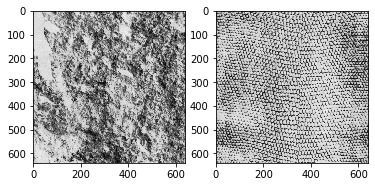

In [3]:
import os
import random

patch_size = (32, 32)
extraction_step = patch_size
n_components = 3
eps = 1e-16

path = '../../data/brodatz'
imgs = [cv2.imread(os.path.join(path, f'D{i}.png'), False) for i in range(2, 4)]

patches = [extract_patches_2d(img, patch_size, extraction_step).astype(np.float) for img in imgs]
length, half_length = len(patches[0]), len(patches[0]) // 2
shuffled_indices = list(range(length))
random.shuffle(shuffled_indices)

train_patches = np.vstack([patch[shuffled_indices[:half_length]] for patch in patches])
test_patches = np.vstack([patch[shuffled_indices[half_length:]] for patch in patches])

plt.subplot(1,2,1)
plt.imshow(imgs[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgs[1], cmap='gray')

## Dictionary Learning

$$\mathop{\rm{minimize}}_{\mathcal{D}, W}\ \frac{1}{2}\sum_{i=1}^n\left\|\sum_{j=1}^mw_{ij}\log_{x_i}(a_j)\right\|_{x_i}^2 + \lambda\|W\|_1\quad
\text{subject to}\ a_j \in \mathcal{P}(r),\ \sum_{j=1}^m w_{ij} = 1$$

画像

In [4]:
# %%time
from typing import List

def extract_feature(patches: np.ndarray, eps: float=1e-8):
    n_patches, p_h, p_w = patches.shape
    res = np.empty((n_patches, p_h * p_w, 5))
    kernel_x = np.array([[0,0,0],[-1,0,1],[0,0,0]])
    kernel_y = np.array([[0,-1,0],[0,0,0],[0,1,0]])
    kernel_xx = np.array([[0,0,0],[-1,2,-1],[0,0,0]])
    kernel_yy = np.array([[0,-1,0],[0,2,0],[0,-1,0]])

    res[:,:,1] = np.vstack([np.abs(cv2.filter2D(p, cv2.CV_64F, kernel_x)) for p in patches]).reshape(-1, p_h * p_w)
    res[:,:,2] = np.vstack([np.abs(cv2.filter2D(p, cv2.CV_64F, kernel_y)) for p in patches]).reshape(-1, p_h * p_w)
    res[:,:,3] = np.vstack([np.abs(cv2.filter2D(p, cv2.CV_64F, kernel_xx)) for p in patches]).reshape(-1, p_h * p_w)
    res[:,:,4] = np.vstack([np.abs(cv2.filter2D(p, cv2.CV_64F, kernel_yy)) for p in patches]).reshape(-1, p_h * p_w)
    res[:,:,0] = patches.reshape(-1, p_h * p_w)
    return np.array([np.cov(x, rowvar=False) + np.eye(5) * eps for x in res])

train_feature = extract_feature(train_patches)
test_feature = extract_feature(test_patches)

## Sparse Coding

### Symmetrix Positive Definite Matrix

In [5]:
%%time
max_iter = 10
dl = DL(
    n_components = n_components ** 2,
    max_iter = max_iter,
    extended_output = True,
    initial_step = 1,
    armijo_param = 1e-4,
    max_iter_dl = 10,
    rho = 1e-4,
    tau = len(train_patches),
    max_iter_sp = 100
)

dl.fit(train_feature)

100%|██████████| 10/10 [09:05<00:00, 54.50s/it]

CPU times: user 3min 39s, sys: 45.9 s, total: 4min 25s
Wall time: 9min 5s


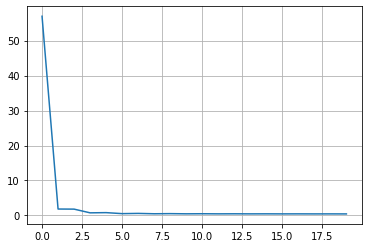

In [6]:
plt.plot(dl.f)
plt.grid(True)
plt.show()

In [7]:
%time train_transformed = dl.transform(train_feature)
%time test_transformed = dl.transform(test_feature)

CPU times: user 204 ms, sys: 10.1 ms, total: 214 ms
Wall time: 1.78 s
CPU times: user 178 ms, sys: 17.8 ms, total: 195 ms
Wall time: 1.74 s


## SVM

### Symmetric Positive Definite Matrix

In [8]:
from sklearn.svm import SVC

label = np.hstack([np.ones(half_length), -np.ones(half_length)])
clf = SVC(C=1e4, gamma='auto', random_state=0)
clf.fit(train_transformed, label)
predicted = clf.predict(test_transformed)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
print(f'Accuracy: {accuracy_score(label, predicted)}')
print(f'Precision: {precision_score(label, predicted)}')
print(f'Recall: {recall_score(label, predicted)}')

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


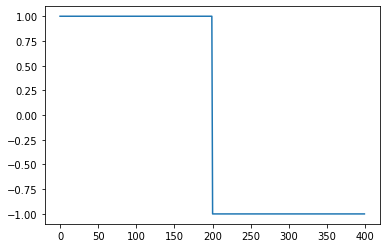

In [10]:
plt.plot(predicted)